# Setup

In [1]:
from ultralytics import YOLO, RTDETR
from matplotlib import pyplot as plt
import cv2
import torch
import os
import numpy as np
import random
import json
import sys
from datetime import datetime

# os.environ['CUDA_VISIBLE_DEVICES'] = "0, 1, 2, 3" # replace with the GPU IDs that are available

# to help with reproducibility
seed=0
import torch.backends.cudnn as cudnn 
random.seed(seed) 
np.random.seed(seed) 
torch.manual_seed(seed) 
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)   
cudnn.benchmark, cudnn.deterministic = False, True

from xami_model.model_predictor import xami
from xami_model.losses import metrics_utils

In [2]:
device_id=1
batch_size=8
torch.cuda.set_device(device_id)

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
yolo_dataset_path = './xami_dataset_zip/xami_dataset_yolov8/'
coco_data_path = './xami_dataset_zip/xami_dataset_coco/'
annotations_file = '_annotations.coco.json'

In [ ]:
import yaml

with open(yolo_dataset_path+f"data.yaml", 'r') as stream:
    yam_data = yaml.safe_load(stream) # dictionary with keys 'names', 'nc', 'train', 'val'

classes = {i:name for i, name in enumerate(yam_data['names'])}
train_path = yam_data['train']
val_path = yam_data['val']
print('Clases:', classes)
    
train_dir = yolo_dataset_path+f'train/images/'
valid_dir = yolo_dataset_path+f'valid/images/'
train_image_files = os.listdir(train_dir)
valid_image_files = os.listdir(valid_dir)
train_num_batches = len(train_image_files) // batch_size
valid_num_batches = len(valid_image_files) // batch_size

## Model setup

In [ ]:
from xami_model.mobile_sam.mobile_sam import sam_model_registry, SamPredictor

device = f"cuda:{device_id}" if torch.cuda.is_available() else "cpu"
# mobile_sam_checkpoint = './output_1_21/xami_final.pth'  # 24 best 25
# mobile_sam_checkpoint = './output_1_24/xami_final.pth' # 24 last 25

# -- RT-DETR backbone
# mobile_sam_checkpoint = './output_1_19/xami_final.pth' # rtdetr best
# detr_weights = './rt-detr-0/rtdetr-l2/weights/best.pt' 
# detector_pretrained_model = RTDETR(detr_weights); 

# -- YOLO backbone
mobile_sam_checkpoint = './output_1_28/xami_final.pth'
detr_weights = './yolov8-segm-0/yolov8n-seg24/weights/best.pt'
detector_pretrained_model = YOLO(detr_weights); 

detector_pretrained_model.to(device);
mobile_sam_model = sam_model_registry["vit_t"](checkpoint=mobile_sam_checkpoint)
mobile_sam_model.to(device)
predictor = SamPredictor(mobile_sam_model)

In [ ]:
xami_model = xami.XAMI(
    mobile_sam_model, 
    device, 
    predictor, 
    use_yolo_masks=True, # this works only for YOLO as detection model
    wt_threshold=0.6, 
    wt_classes_ids = [1.0, 4.0])

# Performance evaluation

This section provides some methods to evaluate the perormance of our model.

In [ ]:
# eval
v_results = xami_model.run_yolo_sam_epoch(
    detector_pretrained_model,
    phase='evaluation',
    batch_size=batch_size,
    image_files=valid_image_files,
    images_dir=valid_dir,
    num_batches=valid_num_batches,
    optimizer=None)

In [ ]:
v_results.keys()

In [ ]:
_, _, _, _, v_aligned_ious = metrics_utils.match_predictions_to_gts(
    v_results['all_preds'], 
    v_results['all_gts'], 
    v_results['all_pred_cls'],
    v_results['all_gt_cls'])
print("Overall True Positive IoUs\n", '\nMean', np.mean(v_aligned_ious), '\nStd', np.std(v_aligned_ious), \
      '\nMedian', np.median(v_aligned_ious))

## Mask IoU metrics

**annotations IoU**

In [ ]:
v_ious = metrics_utils.ann_ious(v_results, 'Validation')
t_ious = metrics_utils.ann_ious(t_results, 'Train')

metrics_utils.plot_ious(t_ious, v_ious, box_anchor=(0.63, 0.285), save=True, save_path='./ious.png')

**IoUs per images**

In [ ]:
img_ious = []

for img_preds, img_gts in zip(v_results['all_gts'], v_results['all_preds']):
    _, _, _, img_iou = metrics_utils.compute_metrics_with_range(img_preds, img_gts)
    img_ious.append(img_iou)
print('Images (Validation)\nMean', np.mean(img_ious), 'Std:', np.std(img_ious), \
     '\nMedian:', np.median(img_ious))

## Metrics per class

In [ ]:
import pandas as pd

data=[]

overall_tp_ious, overall_fp_ious, overall_fn_ious, class_metrics, cls_det = metrics_utils.iou_cls_tp_fp_fn(
    v_results['all_preds'],
    v_results['all_gts'],
    v_results['all_pred_cls'],
    v_results['all_gt_cls'])

for cls, metrics in class_metrics.items():
    tp_count = len(metrics['tp_ious'])
    fp_count = len(metrics['fp_ious'])
    fn_count = len(metrics['fn_ious'])
    
    recall_det = np.round(tp_count / (tp_count + fn_count) * 100, 2) if (tp_count + fn_count) > 0 else 0.0
    precision_det = np.round(tp_count / (tp_count + fp_count) *100, 2) if (tp_count + fp_count) > 0 else 0.0
    perc_fp = np.round(fp_count / (tp_count + fp_count + fn_count) * 100, 2) if (tp_count + fp_count + fn_count) > 0 else 0.0
    perc_fn = np.round(fn_count / (tp_count + fp_count + fn_count) * 100, 2) if (tp_count + fp_count + fn_count) > 0 else 0.0
    iou_tp = np.round(np.mean(metrics['tp_ious']), 2)
    data.append([cls, precision_det, recall_det, perc_fp, perc_fn, iou_tp])

df = pd.DataFrame(data, columns=['Class', 'Prec', 'Recall', 'FP', 'FN', 'IoU_TP'])
df

In [ ]:
np.mean(df['Prec']), np.mean(df['Recall']), np.mean(df['FP']), np.mean(df['FN']), np.mean(df['IoU_TP'])

## IoU plots 

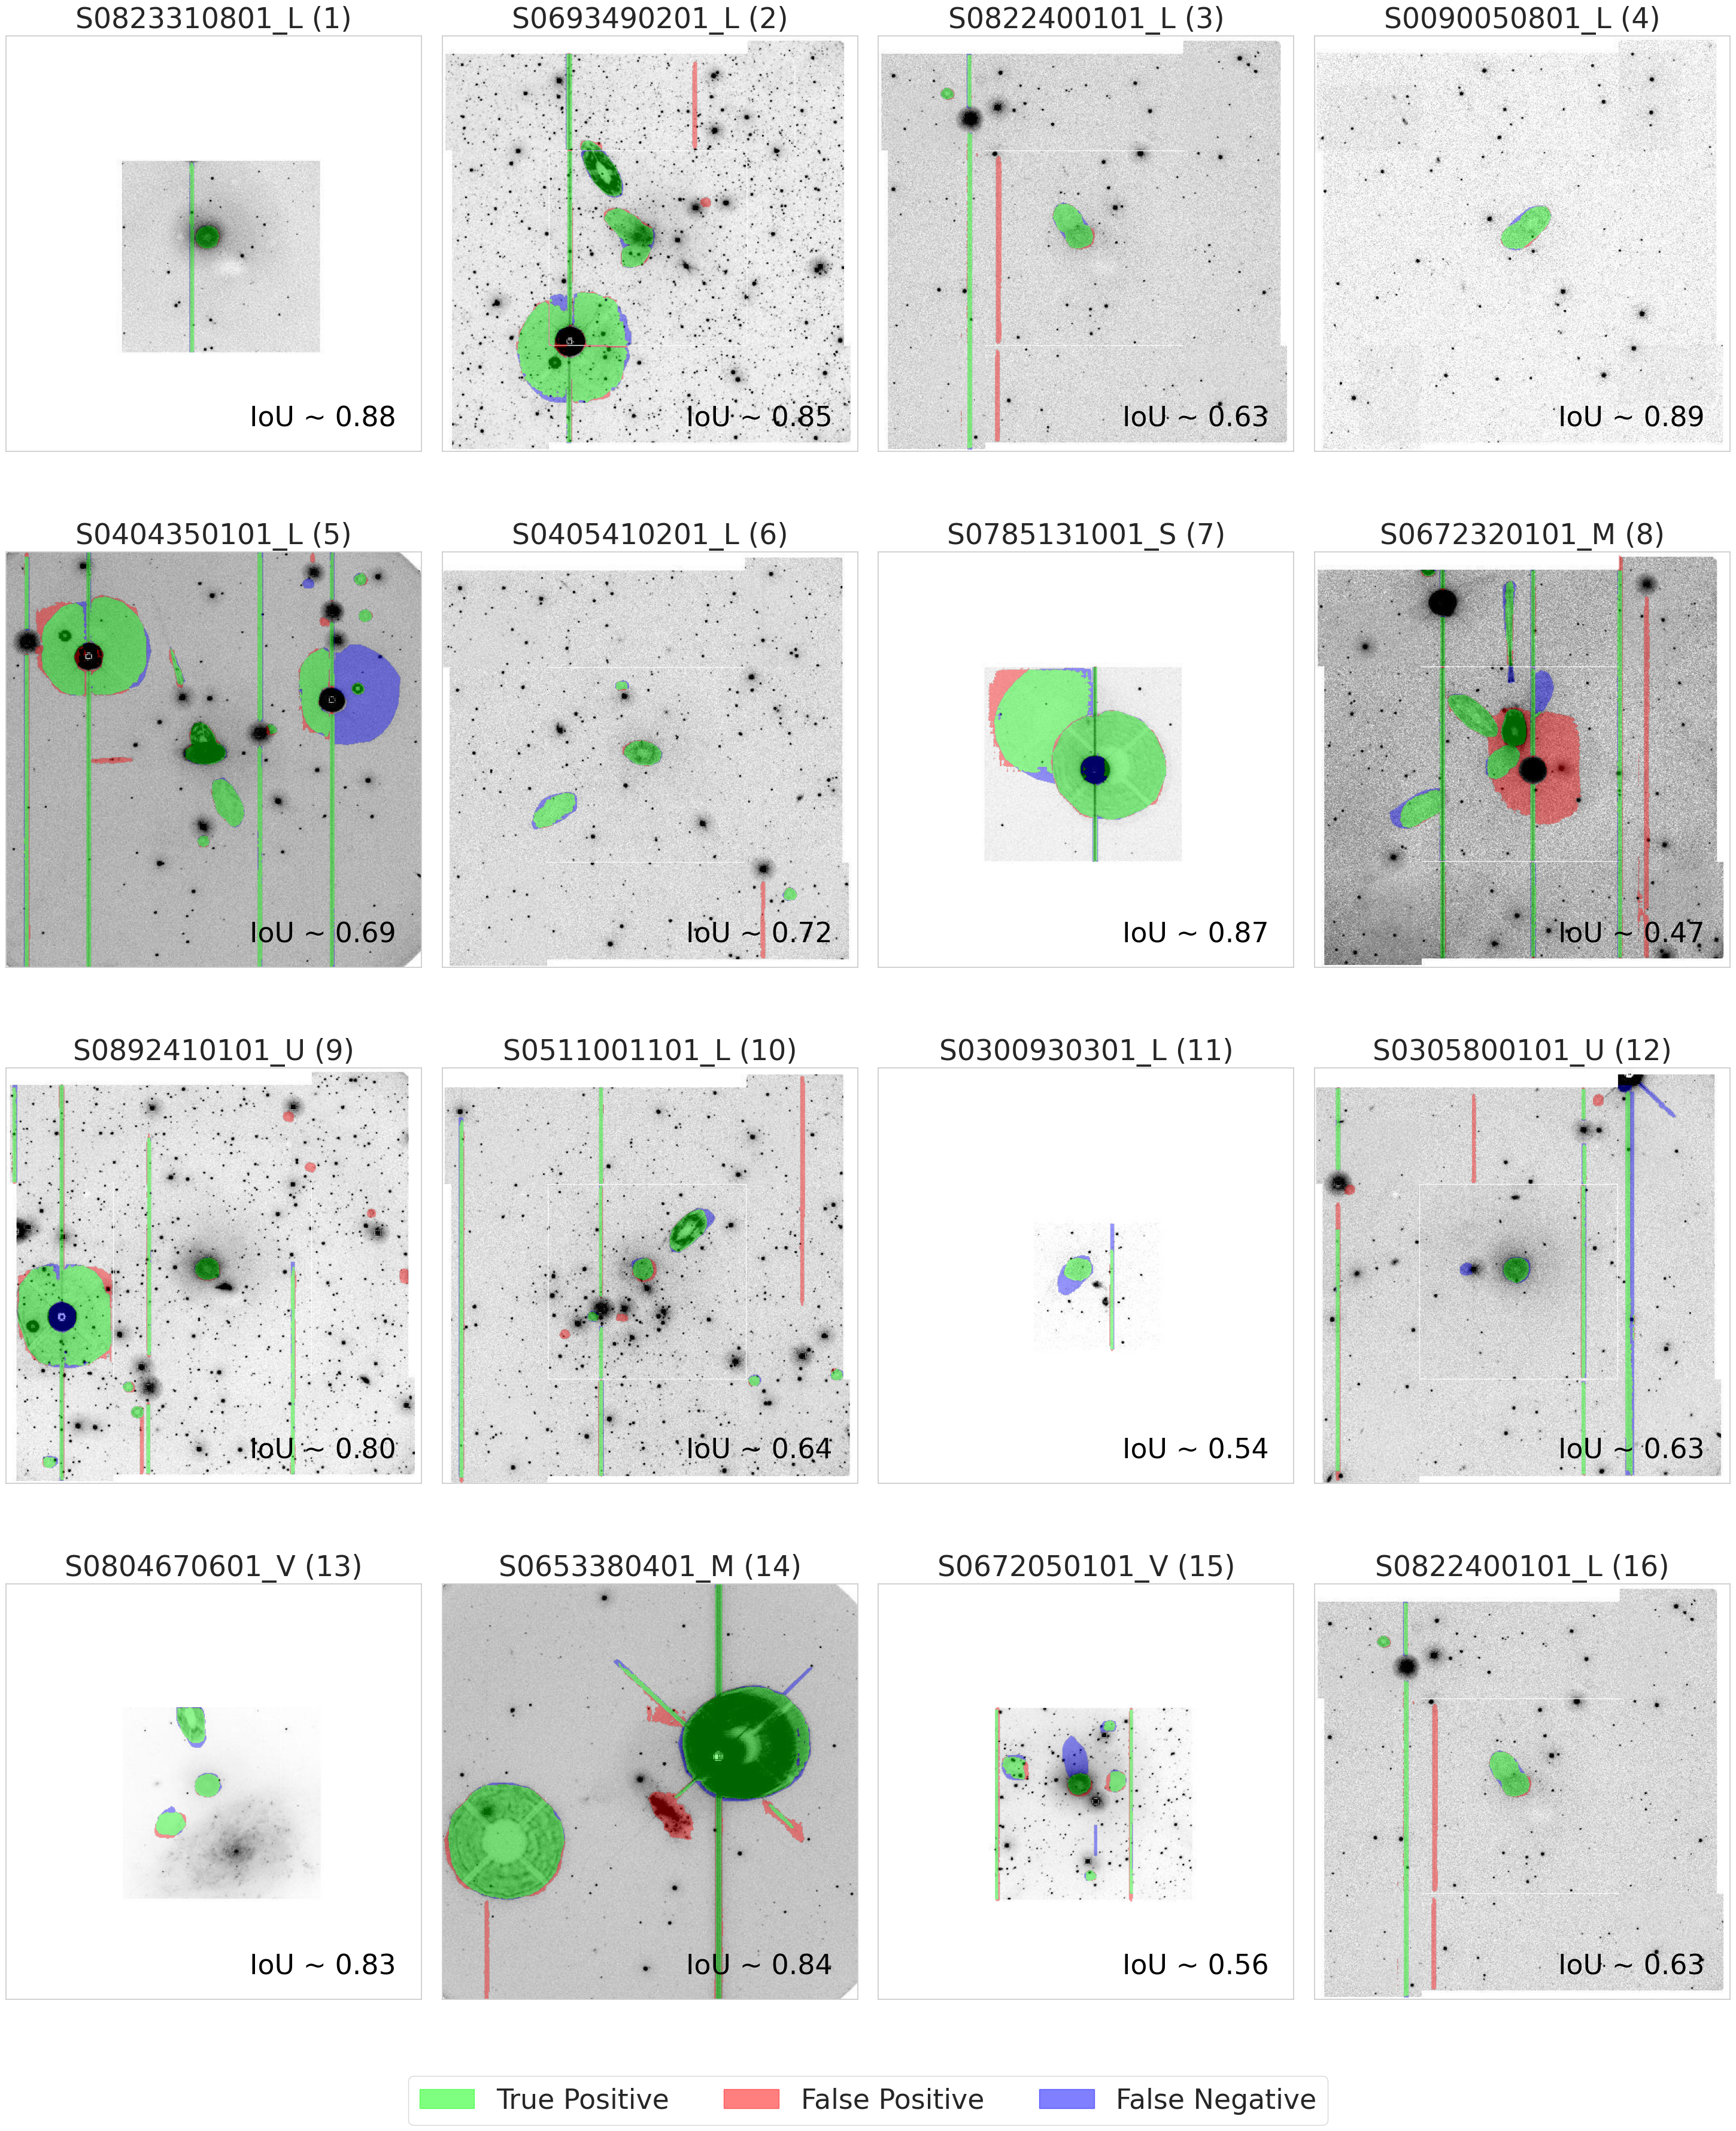

In [15]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cv2

num_samples = 16
# random_indices = random.sample(range(len(v_results['v_pred_images'])), num_samples)
random_indices = [91, 231, 187, 120, 230, 235, 178, 247, 196, 201, 52, 117, 129, 161, 172, 187] 
# random_indices = [52, 92, 3, 46, 109, 158, 64, 79, 88, 104, 117, 129, 161, 172, 187, 200]
images = [v_results['pred_images'][i] for i in random_indices]
selected_preds = [v_results['all_preds'][i] for i in random_indices]

fig, axes = plt.subplots(4, 4, figsize=(36, 36))

for j, (image_name, pred_mask) in enumerate(zip(images, selected_preds)):
    row, col = divmod(j, 4)
    gt_masks = v_results['all_gts'][random_indices[j]]

    image = cv2.imread(valid_dir + image_name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ax_simple = axes[row, col]
    ax_simple.imshow(255-image)
    ax_simple.set_xticks([])
    ax_simple.set_yticks([])
    ax_simple.set_title(f'{image_name[:13]} ({j+1})', fontsize=34, pad=10)

    tp_color = np.array([0, 255, 0, 102]) / 255  
    fp_color = np.array([255, 0, 0, 102]) / 255  
    fn_color = np.array([0, 0, 255, 102]) / 255  

    true_positive_mask, false_positive_mask, false_negative_mask, iou = metrics_utils.compute_metrics_with_range(gt_masks, pred_mask, image)
    h, w = true_positive_mask.shape[-2:]
    true_positive_mask = true_positive_mask.reshape(h, w, 1) * tp_color.reshape(1, 1, -1)
    false_positive_mask = false_positive_mask.reshape(h, w, 1) * fp_color.reshape(1, 1, -1)
    false_negative_mask = false_negative_mask.reshape(h, w, 1) * fn_color.reshape(1, 1, -1)

    ax_simple.imshow(false_positive_mask)
    ax_simple.imshow(false_negative_mask)
    ax_simple.imshow(true_positive_mask)

    ax_simple.text(300, 480, f'IoU ~ {iou:.2f}', fontsize=33, color='black')

tp_patch = mpatches.Patch(color=tp_color, label='True Positive', alpha=0.5)
fp_patch = mpatches.Patch(color=fp_color, label='False Positive', alpha=0.5)
fn_patch = mpatches.Patch(color=fn_color, label='False Negative', alpha=0.5)

fig.legend(handles=[tp_patch, fp_patch, fn_patch], loc='lower center', bbox_to_anchor=(0.5, -0.0003), ncol=3, fontsize=33)
plt.tight_layout(pad=0.1)
plt.subplots_adjust(left=0.1, right=0.9, top=0.99, bottom=0.05, hspace=0.08, wspace=0.05)
# plt.savefig('tp_fp_fn_ious.pdf', dpi=600)
plt.show()